Target: 10
Loop has finished. Stopping Car.


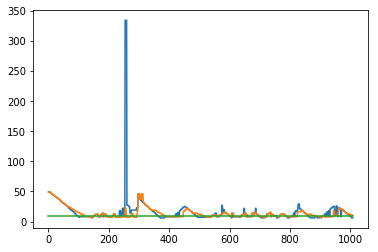

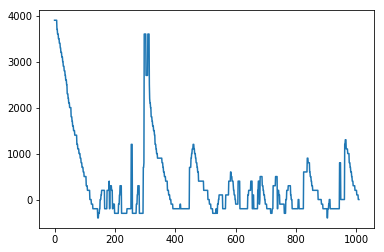

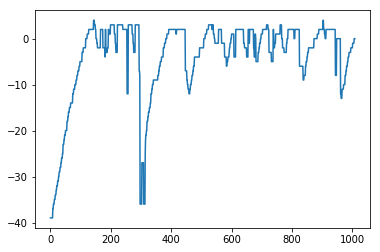

In [6]:
#PID WALL DISTANCE EXERCISE
#ONLY P VERSION

from easygopigo3 import EasyGoPiGo3
from EDL_Jupyter_resources import HiddenPrints
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
hiddenprints=HiddenPrints()

# Initialize easy gpg
easyGPG = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
easyGPG.reset_all()

###SENSORS###
US_sensor=easyGPG.init_ultrasonic_sensor('AD1')

###INITIALIZING VARIABLES###
data=np.array([]) #this will be our running list of distance data
zero_error_tally=0 #this will record when we are at our target
telemetry=[] #debugging

###CONSTANTS###
sample_rate=60 #samples/sec for US sensor
kp=100#proportional constant

###PRE LOOP TASKS###
target=int(input('Target: ')) #this is our offset target to reach from our current pos.  
easyGPG.stop()  #stop the car if its running

###FUNCTIONS###
def catch_erroneous(data,band):
    '''This function checks the last few readings in a data set 
    (length "band") to ensure that the most recent
    reading is reasonable (meaning not super far from the rest of them)
    It then return the most recent reasonable reading.'''
    
    current_reading=0
    
    if len(data)<band:
        band=len(data)
        
    mean=np.mean(data[len(data)-band:len(data)])
    
    for i in range(band):
        current_reading=data[len(data)-i-1]
        if current_reading<((2/3.0)*mean) or current_reading>((3/2.0)*mean):
            continue
        else:
            break
        
    return current_reading

def proportional_check(kp,error): 
    '''Return the difference between
    where we are and where we want to be
    multiplied by derivative constant'''
    return(kp*error) 

def check_wall(kp,target,data):
    '''This function takes a kp, target dist, and previous dataset.
    It reads the US sensor, makes sure it is a reasonable reading,
    and then based on that reading uses proportional control to 
    steer the GoPiGo. It then reports telemetry data and passes the 
    new dataset and current error value on through the return. '''
    with hiddenprints: #read the distance 
        reading=US_sensor.read()
        
    if reading<=5:
        reading=data[-1]

    data=np.append(data,reading) #add the reading to the dataset
    
    adjusted_reading=catch_erroneous(data,int(sample_rate)) #clean the data

    error=adjusted_reading-target #calculate the error
    
    P=proportional_check(kp,error) #run a proportional check on our error
    
    easyGPG.steer(P,P) #steer the GPG depending on the P value
    
    telemetry.append([[reading,adjusted_reading],data,P]) #debugging
    
    return(data,error) #return the new dataset and error set

###LOOP###
start=time.time() #start the clock 
while time.time()-start<20: #run for 20 sec max

    data,error=check_wall(kp,target,data) #check the wall and return the dataset 
    time.sleep((1.0/sample_rate)) #sleep until the next reading
    
    if abs(error)<1:
        zero_error_tally=zero_error_tally+1
    else:
        zero_error_tally=0

    if zero_error_tally>=sample_rate:
        print('We made it!')
        break

print('Loop has finished. Stopping Car.')
    
easyGPG.stop() #stop the car

###DEBUGGING###
pos=[] #debugging lists
apos=[]
err=[]
parry=[]
x=[]
for i in range(len(telemetry)): #debugging lists
    #position and error data
    POS=telemetry[i][0][0]
    adjustedPOS=telemetry[i][0][1]
    ERR=target-adjustedPOS
    pos.append(POS)
    apos.append(adjustedPOS)
    err.append(ERR)
    #PID data
    p=telemetry[i][2]
    parry.append(p)
    
    x.append(i) #x value is # of samples
    
target_array=np.empty(len(x)) #for making the target line
target_array.fill(target)

plt.figure(0)
plt.plot(x,pos) #plot pos vs time
plt.plot(x,apos)#plot actual pos vs time
plt.plot(x,target_array) #plot the target line
plt.figure(1)
plt.plot(x,parry) #plot pid stats vs time
plt.figure(2)
plt.plot(x,err) #plot the error vs time
plt.show()

In [ ]:
#PID WALL DISTANCE EXERCISE
#ONLY P and D VERSION

from easygopigo3 import EasyGoPiGo3
from EDL_Jupyter_resources import HiddenPrints
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
hiddenprints=HiddenPrints()

# Initialize easy gpg
easyGPG = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
easyGPG.reset_all()

###SENSORS###
US_sensor=easyGPG.init_ultrasonic_sensor('AD1')

###INITIALIZING VARIABLES###
data=np.array([]) #this will be our running list of distance data
error_set=np.array([]) #this will be our array of error values
zero_error_tally=0 #this will record when we are at our target
telemetry=[] #debugging

###CONSTANTS###
mem_size=4 #this is how far back the derivative check looks (in datapoints)
sample_rate=60 #samples/sec for US sensor

kp=5#proportional constant
kd=0 #derivative constant

###PRE LOOP TASKS###
target=int(input('Target: ')) #this is our offset target to reach from our current pos.  
easyGPG.stop()  #stop the car if its running

###FUNCTIONS###
def catch_erroneous(data,band):
    #find the previous non erroneous reading
    
    current_reading=0
    
    if len(data)<band:
        band=len(data)
        
    mean=np.mean(data[len(data)-band:len(data)])
    
    for i in range(band):
        current_reading=data[len(data)-i-1]
        if current_reading<((2/3.0)*mean) or current_reading>((3/2.0)*mean):
            continue
        else:
            break
        
    return current_reading

    
def proportional_check(kp,error_set): 
    '''Return the difference between
    where we are and where we want to be
    multiplied by derivative constant'''
    f=error_set[len(error_set)-1] #get the most recent error
    return(kp*(f)) 

def derivative_check(kd,error_set):
    '''Look at a history of error
    and determine how fast that error set
    is changing over that history. The 
    larger the slope, the larger the correction 
    against the direction of that slope'''
    f=error_set[len(error_set)-1] #get the most recent error
    i=error_set[len(error_set)-(mem_size)] #get the first error in mem_size
    slope=(f-i)/float(mem_size) #take the slope between them (derivative)
    return(kd*slope) 

def check_wall(kp,kd,target,data,error_set):
    
    with hiddenprints: #read the distance 
        reading=US_sensor.read()
        
    if reading<=5:
        reading=data[-1]

    data=np.append(data,reading) #add the reading to the dataset
    
    adjusted_reading=catch_erroneous(data,int(sample_rate))

    error_set=np.append(error_set,adjusted_reading-target) #add the error to the error set
    
    P=proportional_check(kp,error_set) #run a proportional check on our error
    
    if len(data)>=mem_size: #if the dataset is long enough to get derivative/integral data,
        D=derivative_check(kd,error_set) #run a derivative check on the datapoint
    else:
        D=0 #otherwise, don't use the derivative check yet.
    
    easyGPG.steer(P+D,P+D) #steer the GPG depending on the P and D values
    
    telemetry.append([[reading,adjusted_reading],data,P,D]) #debugging
    
    return((data,error_set)) #return the new dataset and error set

###LOOP###
start=time.time() #start the clock 
while time.time()-start<20: #run for 10 sec

    data,error_set=check_wall(kp,kd,target,data,error_set) #check the wall and return the dataset 
    time.sleep((1.0/sample_rate)) #sleep until the next reading
    
    if abs(error_set[-1])<1:
        zero_error_tally=zero_error_tally+1
    else:
        zero_error_tally=0

    if zero_error_tally>=sample_rate:
        print('We made it!')
        break

print('Loop has finished. Stopping Car.')
    
easyGPG.stop() #stop the car

###DEBUGGING###
pos=[] #debugging lists
apos=[]
err=[]
parry=[]
darry=[]
x=[]
for i in range(len(telemetry)): #debugging lists
    #position and error data
    POS=telemetry[i][0][0]
    adjustedPOS=telemetry[i][0][1]
    ERR=target-adjustedPOS
    pos.append(POS)
    apos.append(adjustedPOS)
    err.append(ERR)
    #PID data
    p=telemetry[i][2]
    d=telemetry[i][3]
    parry.append(p)
    darry.append(d)
    
    x.append(i) #x value is # of samples
    
target_array=np.empty(len(x)) #for making the target line
target_array.fill(target)

plt.figure(0)
plt.plot(x,pos) #plot pos vs time
plt.plot(x,apos)#plot actual pos vs time
plt.plot(x,target_array) #plot the target line
plt.figure(1)
plt.plot(x,parry) #plot pid stats vs time
plt.plot(x,darry)
plt.figure(2)
plt.plot(x,err) #plot the error vs time
plt.show()

In [ ]:
#PID WALL DISTANCE EXERCISE
# P, D, and I VERSION

from easygopigo3 import EasyGoPiGo3
from EDL_Jupyter_resources import HiddenPrints
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
hiddenprints=HiddenPrints()

# Initialize easy gpg
easyGPG = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
easyGPG.reset_all()

US_sensor=easyGPG.init_ultrasonic_sensor('AD1')

data=np.array([]) #this will be our running list of distance data
error_set=np.array([]) #this will be our array of error values
mem_size=4 #this is how far back the derivative check looks (in datapoints)
sample_rate=60 #samples/sec for US sensor
I_tally=0 #integral tally

kp=5#proportional constant
kd=50 #derivative constant
ki=0#0.05#integral constant

target=int(input('Target: ')) #this is our offset target to reach from our current pos.

telemetry=[] #debugging
    
easyGPG.stop()  #stop the car if its running

def catch_erroneous(data,band):
    #find the previous non erroneous reading
    
    current_reading=0
    
    if len(data)<band:
        band=len(data)
        
    mean=np.mean(data[len(data)-band:len(data)])
    
    for i in range(band):
        current_reading=data[len(data)-i-1]
        if current_reading<((2/3.0)*mean) or current_reading>((3/2.0)*mean):
            continue
        else:
            break
        
    return current_reading

    
def proportional_check(kp,error_set): 
    '''Return the difference between
    where we are and where we want to be
    multiplied by derivative constant'''
    f=error_set[len(error_set)-1] #get the most recent error
    return(kp*(f)) 

def derivative_check(kd,error_set):
    '''Look at a history of error
    and determine how fast that error set
    is changing over that history. The 
    larger the slope, the larger the correction 
    against the direction of that slope'''
    f=error_set[len(error_set)-1] #get the most recent error
    i=error_set[len(error_set)-(mem_size)] #get the first error in mem_size
    slope=(f-i)/float(mem_size) #take the slope between them (derivative)
    return(kd*slope) 

def integral_check(ki,I_tally,error_set):
    '''Look at the magnitude, and duration
    of the error in the system. Adjust depending
    on that error'''
    I_tally=I_tally+error_set[-1]
    return(ki*I_tally,I_tally)

def check_wall(kp,kd,ki,target,data,error_set,I_tally):
    
    with hiddenprints: #read the distance 
        reading=US_sensor.read()
        
    if reading<=5:
        reading=data[-1]

    data=np.append(data,reading) #add the reading to the dataset
    
    adjusted_reading=catch_erroneous(data,int(sample_rate))

    error_set=np.append(error_set,adjusted_reading-target) #add the error to the error set
    
    P=proportional_check(kp,error_set) #run a proportional check on our error
    
    if len(data)>=mem_size: #if the dataset is long enough to get derivative/integral data,
        D=derivative_check(kd,error_set) #run a derivative check on the datapoint
    else:
        D=0 #otherwise, don't use the derivative check yet.
    
    if not abs(P+D)>=80: #if we're not already trying as hard as possible to get where we're going
        I,I_tally=integral_check(ki,I_tally,error_set) #run an integral check on our error
    else: #otherwise we shouldn't add to the error
        I=0
        I_tally=0
    
    easyGPG.steer(P+D+I,P+D+I) #steer the GPG depending on the P and D values
    
    telemetry.append([[reading,adjusted_reading],data,P,D,I,error_set]) #debugging
    
    return((data,error_set,I_tally)) #return the new dataset and error set
    
start=time.time() #start the clock 
while time.time()-start<20: #run for 10 sec

    data,error_set,I_tally=check_wall(kp,kd,ki,target,data,error_set,I_tally) #check the wall and return the dataset 
    time.sleep((1.0/sample_rate)) #sleep until the next reading
    
    if error_set[-1]<0.5:
    
easyGPG.stop() #stop the car

pos=[] #debugging lists
apos=[]
err=[]
parry=[]
darry=[]
iarry=[]
x=[]
for i in range(len(telemetry)): #debugging lists
    #position and error data
    POS=telemetry[i][0][0]
    adjustedPOS=telemetry[i][0][1]
    ERR=target-adjustedPOS
    pos.append(POS)
    apos.append(adjustedPOS)
    err.append(ERR)
    #PID data
    p=telemetry[i][2]
    d=telemetry[i][3]
    i_=telemetry[i][4]
    parry.append(p)
    darry.append(d)
    iarry.append(i_)
    
    x.append(i) #x value is # of samples
    
target_array=np.empty(len(x)) #for making the target line
target_array.fill(target)

plt.figure(0)
plt.plot(x,pos) #plot pos vs time
plt.plot(x,apos)#plot actual pos vs time
plt.plot(x,target_array) #plot the target line
plt.figure(1)
plt.plot(x,parry) #plot pid stats vs time
plt.plot(x,darry)
plt.plot(x,iarry)
plt.figure(2)
plt.plot(x,err) #plot the error vs time
plt.show()

print('Steady state error was: %f'%(float(err[-1])))

In [ ]:
#EMERGENCY STOP
from easygopigo3 import EasyGoPiGo3
# Initialize easy gpg
easyGPG = EasyGoPiGo3()
# Make sure that all sensors and output devices are uncofigured to start
easyGPG.reset_all()
easyGPG.stop()